На проекті, де користувач може відправити лайк іншому користувачу, для збільшення кількості відправлених лайків провели тест на заміну іконки на кнопці з серця на галочку.  При нажатті на хрестик користувача пропонується наступний користувач. Тестовий варіант запустили на користувачів з непарним sender_id 24 березня о 16:00, на парних користувачах залишили базовий варіант.

План дій:
1. Огляд даних
2. Предобробка даних
3. Аналіз даних
4. Аналіз АБ тесту
5. Висновки

Доступні дані:
* sender_id - id користувача
* platform_id - id платформи
* time_stamp - час виконання дії
* gender - гендер користувача
* reg_date - дата реєстрації

In [802]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from tqdm import tqdm

In [803]:
!ls

README.md  ab_test.ipynb  df.csv


In [804]:
df = pd.read_csv('df.csv', sep=';')

In [805]:
start_date = '2017-03-24 16:00:00'

# 1. Огляд даних

In [806]:
df.head()

,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,16.03.2017 13:35,m,26.01.2017
1,3207526951,6,16.03.2017 9:09,m,26.01.2017
2,3207526951,6,16.03.2017 9:09,m,26.01.2017
3,3207526951,6,16.03.2017 12:13,m,26.01.2017
4,3207526951,6,15.03.2017 14:01,m,26.01.2017


In [807]:
df.shape

(768439, 5)

In [808]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768439 entries, 0 to 768438
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sender_id    768439 non-null  int64 
 1   platform_id  768439 non-null  int64 
 2   time_stamp   768439 non-null  object
 3   gender       768439 non-null  object
 4   reg_date     768439 non-null  object
dtypes: int64(2), object(3)
memory usage: 29.3+ MB


In [809]:
df.duplicated().sum()

518178

In [810]:
df.isnull().sum()

sender_id      0
platform_id    0
time_stamp     0
gender         0
reg_date       0
dtype: int64

In [811]:
df.nunique()

sender_id      26321
platform_id        2
time_stamp     20100
gender             3
reg_date          85
dtype: int64

In [812]:
df['gender'].unique()

array(['m', 'f', ' '], dtype=object)

In [813]:
df.describe()

,sender_id,platform_id
count,7.684390e+05,768439.000000
mean,3.212627e+09,6.419483
std,5.060134e+06,0.493475
min,3.201944e+09,6.000000
25%,3.208266e+09,6.000000
50%,3.214114e+09,6.000000
75%,3.216958e+09,7.000000
max,3.219311e+09,7.000000


In [814]:
df.describe(include='object')

,time_stamp,gender,reg_date
count,768439,768439,768439
unique,20100,3,85
top,14.03.2017 14:26,m,13.03.2017
freq,239,659569,31548


В даних виявлено наступні помилки:
* неправильний формат у стовпцях 'time_stamp' та 'reg_date'
* наявність дублікатів
* в стовпці 'gender' присутні пропуски

# 2. Предобробка даних

In [815]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'], dayfirst=True)
df['reg_date'] = pd.to_datetime(df['reg_date'], dayfirst=True)

In [816]:
df['gender'].value_counts()

gender
m    659569
f    108699
        171
Name: count, dtype: int64

In [817]:
df['gender'] = df['gender'].replace({' ': np.nan})

In [818]:
df[df['gender'].isna()].sample(20)

,sender_id,platform_id,time_stamp,gender,reg_date
109632,3215997599,7,2017-03-15 12:54:00,NaN,2017-03-09
109629,3215997599,7,2017-03-13 13:07:00,NaN,2017-03-09
340367,3216008283,6,2017-03-20 11:28:00,NaN,2017-03-09
340523,3215997599,7,2017-03-22 10:58:00,NaN,2017-03-09
661800,3215997599,7,2017-03-17 09:15:00,NaN,2017-03-09
661621,3216008283,6,2017-03-20 11:28:00,NaN,2017-03-09
307961,3216008283,6,2017-03-26 08:25:00,NaN,2017-03-09
661626,3216008283,6,2017-03-20 11:27:00,NaN,2017-03-09
661622,3216008283,6,2017-03-20 11:28:00,NaN,2017-03-09
495290,3215996422,7,2017-03-15 01:19:00,NaN,2017-03-09


In [819]:
for i in [i for i in df.columns if i != 'gender']:
    print(i, df[df['gender'].isna()][i].nunique())

sender_id 3
platform_id 2
time_stamp 62
reg_date 1


In [820]:
id_gender_na = df[df['gender'].isna()]['sender_id'].unique()
id_gender_na

array([3216008283, 3215997599, 3215996422])

In [821]:
df[df['sender_id'].isin(id_gender_na)].shape

(171, 5)

In [822]:
df[df['sender_id'].isin(id_gender_na)]['sender_id'].value_counts()

sender_id
3215997599    86
3216008283    49
3215996422    36
Name: count, dtype: int64

In [823]:
df[df['reg_date'] == '2017-03-09']['sender_id'].nunique()

369

In [824]:
df[(df['gender'].isna()) & (df['time_stamp'] < start_date)].shape

(148, 5)

Загалом у стовпці gender 171 пропуск, з яких 148 до початку тесту та 23 після. Усі вони належать трьом користувачам, які зареєструвались в один день.

In [825]:
df[df.duplicated()].sample(20)

,sender_id,platform_id,time_stamp,gender,reg_date
753710,3217752133,6,2017-03-18 19:18:00,f,2017-03-18
441209,3214918464,6,2017-03-15 21:17:00,m,2017-03-04
240556,3212806432,6,2017-03-25 18:13:00,m,2017-02-21
645729,3203480390,7,2017-03-26 17:34:00,m,2017-01-08
200909,3207112036,7,2017-03-25 09:18:00,m,2017-01-24
361875,3216071967,7,2017-03-21 08:21:00,m,2017-03-10
606178,3218866775,6,2017-03-26 09:34:00,f,2017-03-24
120523,3205603383,6,2017-03-23 00:21:00,m,2017-01-17
555512,3216653484,6,2017-03-14 01:04:00,f,2017-03-13
399530,3214918464,6,2017-03-17 17:35:00,m,2017-03-04


In [826]:
idd = 3203188184
df[df['sender_id'] == idd].shape, df[df['sender_id'] == idd].duplicated().sum()

((654, 5), 548)

In [827]:
df[df['sender_id'] == idd].sample(20)

,sender_id,platform_id,time_stamp,gender,reg_date
550749,3203188184,7,2017-03-25 23:40:00,m,2017-01-06
187711,3203188184,6,2017-03-25 15:05:00,m,2017-01-06
550748,3203188184,7,2017-03-26 00:02:00,m,2017-01-06
549486,3203188184,7,2017-03-25 21:29:00,m,2017-01-06
188703,3203188184,7,2017-03-25 23:31:00,m,2017-01-06
188623,3203188184,7,2017-03-25 23:00:00,m,2017-01-06
257888,3203188184,6,2017-03-18 23:50:00,m,2017-01-06
550745,3203188184,7,2017-03-25 22:31:00,m,2017-01-06
188456,3203188184,7,2017-03-25 21:25:00,m,2017-01-06
607129,3203188184,6,2017-03-19 13:21:00,m,2017-01-06


In [828]:
df[df.eq(df.iloc[187728]).all(axis=1)]

,sender_id,platform_id,time_stamp,gender,reg_date
187707,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
187708,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
187710,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
187728,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
187733,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
548797,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
548809,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
548810,3203188184,6,2017-03-25 15:03:00,m,2017-01-06
548815,3203188184,6,2017-03-25 15:03:00,m,2017-01-06


In [829]:
idd = 3216436279
df[df['sender_id'] == idd].shape, df[df['sender_id'] == idd].duplicated().sum()

((60, 5), 45)

In [830]:
df[df['sender_id'] == idd].sample(20)

,sender_id,platform_id,time_stamp,gender,reg_date
759696,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
415796,3216436279,7,2017-03-20 10:06:00,m,2017-03-11
270923,3216436279,7,2017-03-25 01:47:00,m,2017-03-11
759712,3216436279,7,2017-03-20 10:05:00,m,2017-03-11
759707,3216436279,7,2017-03-22 11:30:00,m,2017-03-11
415779,3216436279,7,2017-03-20 10:05:00,m,2017-03-11
415788,3216436279,7,2017-03-18 19:16:00,m,2017-03-11
759704,3216436279,7,2017-03-22 11:30:00,m,2017-03-11
759703,3216436279,7,2017-03-23 09:41:00,m,2017-03-11
415789,3216436279,7,2017-03-20 10:05:00,m,2017-03-11


In [831]:
df[df.eq(df.iloc[755797]).all(axis=1)]

,sender_id,platform_id,time_stamp,gender,reg_date
415784,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
415785,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
415800,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
755797,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
755798,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
759696,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
759700,3216436279,7,2017-03-18 19:17:00,m,2017-03-11
759705,3216436279,7,2017-03-18 19:17:00,m,2017-03-11


Дані відображають, як користувачі ставили лайки та дизлайки в додатку. Кількість дій на хвилину може досягати десятків, і всі вони будуть позначені як дублікат.

# 3. Аналіз даних

In [832]:
df.head()

,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,2017-03-16 13:35:00,m,2017-01-26
1,3207526951,6,2017-03-16 09:09:00,m,2017-01-26
2,3207526951,6,2017-03-16 09:09:00,m,2017-01-26
3,3207526951,6,2017-03-16 12:13:00,m,2017-01-26
4,3207526951,6,2017-03-15 14:01:00,m,2017-01-26


In [833]:
df['hour'] = df['time_stamp'].dt.hour

In [834]:
def act_distr(df_copy, column, title=''):
    one, two = [df_copy[df_copy[column] == i] for i in df_copy[column].unique() if i is not np.nan]

    m = one.groupby('hour')['platform_id'].count()
    f = two.groupby('hour')['platform_id'].count()
    
    m_ratio = m / m.sum()
    f_ratio = f / f.sum()
    
    w = 0.3
    
    plt.bar(x=m.index - w/2, height=m_ratio, width=w, label='m')
    plt.bar(x=f.index + w/2, height=f_ratio, width=w, label='f')
    
    plt.legend()
    plt.title(f'Розподіл активності по годинам {title}')
    plt.xlabel('години')
    
    plt.show();

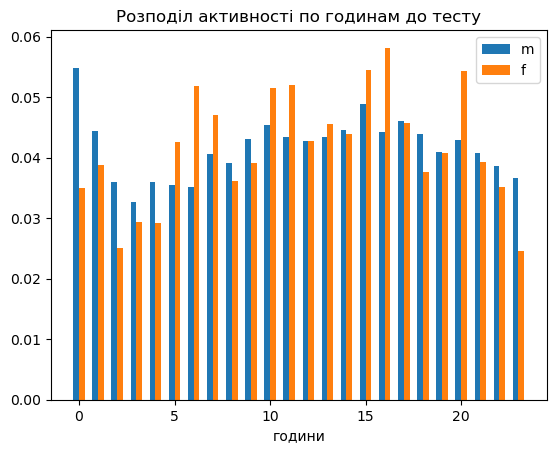

In [835]:
df_bef = df[df['time_stamp'] < start_date].copy()
act_distr(df_bef, 'gender', 'до тесту')

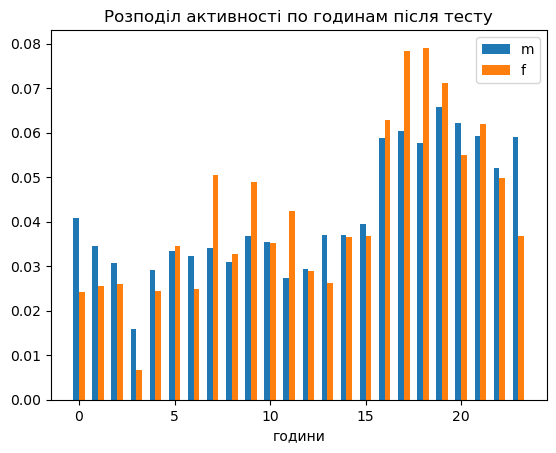

In [836]:
df_aft = df[df['time_stamp'] >= start_date].copy()
act_distr(df_aft, 'gender', 'після тесту')

До початку тесту:
З 21:00 до 4:00 чоловіки більш активні в додатку, пік активності припадає на 24:00. Жінки активні з 5:00 до 20:00, спостерігаються кілька піків: 6:00, 10:00, 11:00, 15:00, 16:00 та 20:00.

Після початку тесту:
Розподіл значно змінився, більшість дій перемістилася на другу половину дня, після 15:00. Чоловіки більш активні з 23:00 до 4:00, пік припадає на 23:00. Жінки активні з 7:00 до 11:00 та з 17:00 до 19:00, пік активності спостерігається з 17:00-19:00.

In [837]:
platform_distr = (df_bef.groupby(['gender', 'platform_id'])['hour'].count() 
                      / df_bef.groupby(['gender'])['hour'].count())

platform_distr

gender  platform_id
f       6              0.725942
        7              0.274058
m       6              0.565039
        7              0.434961
Name: hour, dtype: float64

<Axes: xlabel='gender,platform_id'>

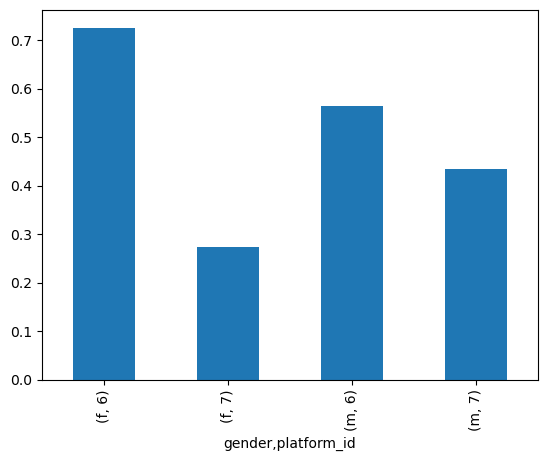

In [838]:
platform_distr.plot(kind='bar')

In [839]:
platform_distr = (df_aft.groupby(['gender', 'platform_id'])['hour'].count() 
                      / df_aft.groupby(['gender'])['hour'].count())

platform_distr

gender  platform_id
f       6              0.583523
        7              0.416477
m       6              0.527100
        7              0.472900
Name: hour, dtype: float64

<Axes: xlabel='gender,platform_id'>

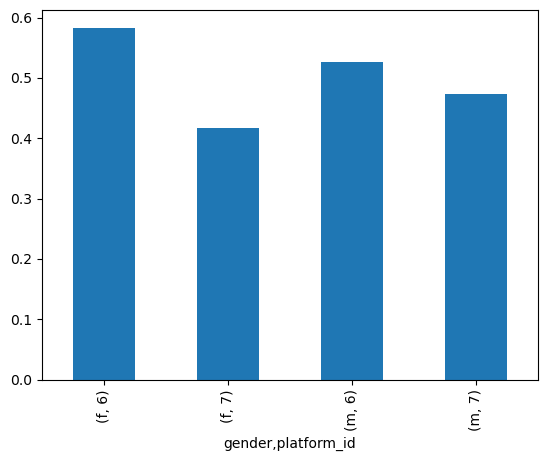

In [840]:
platform_distr.plot(kind='bar')

У жінок значно знизилася частота використання платформи 6, з 72% до 58%. У чоловіків цей показник змінився менш суттєво, з 56% до 52%

In [841]:
def number_of_actions(df, column):
    num_act = pd.DataFrame(df.groupby('sender_id')['platform_id'].count().reset_index())
    num_act.rename(columns={'platform_id': 'number_of_actions'}, inplace=True)

    user_index = df.groupby('sender_id')[column].nunique()
    user_index = user_index[user_index > 1]

    users = df[~df['sender_id'].isin(user_index.index.values)] \
                .groupby('sender_id')[column].agg('first')

    num_act = pd.merge(
        left=num_act[~num_act['sender_id'].isin(user_index.index.values)],
        right=users,
        how='inner',
        on='sender_id'
    )
    
    return num_act

/home/dkolesov95/anaconda3/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


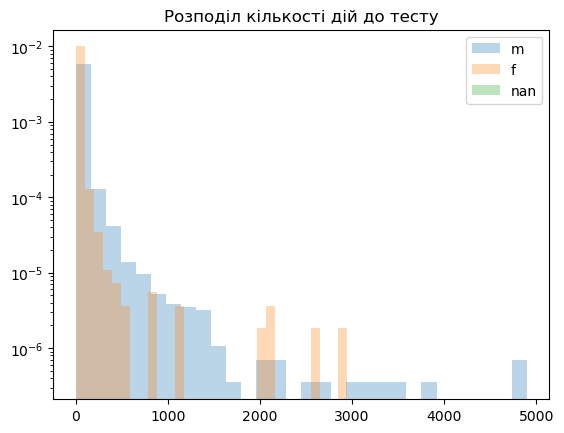

In [842]:
column = 'gender'
num_act_bef = number_of_actions(df_bef, column)

for i in df_bef[column].unique():
    plt.hist(num_act_bef[num_act_bef[column] == i]['number_of_actions'], bins=30, alpha=0.3, label=i, density=True)

plt.title('Розподіл кількості дій до тесту')
plt.legend()
plt.yscale('log')
plt.show();

In [843]:
num_act_bef.groupby(column)['number_of_actions'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
f,5558.0,17.027168,82.296316,1.0,2.0,5.0,13.0,2950.0
m,17464.0,32.408841,124.089962,1.0,2.0,6.0,26.0,4896.0


In [844]:
num_act_bef.groupby(column)['number_of_actions'].agg(lambda x: np.quantile(x, 0.95))

gender
f     53.0
m    124.0
Name: number_of_actions, dtype: float64

/home/dkolesov95/anaconda3/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


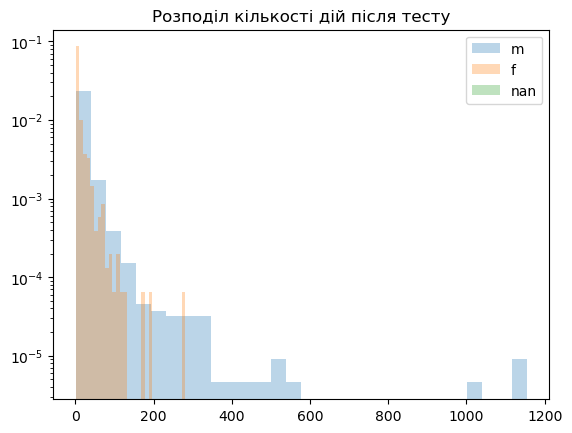

In [845]:
column = 'gender'
num_act_aft = number_of_actions(df_aft, column)

for i in df_aft[column].unique():
    plt.hist(num_act_aft[num_act_aft[column] == i]['number_of_actions'], bins=30, alpha=0.3, label=i, density=True)

plt.title('Розподіл кількості дій після тесту')
plt.legend()
plt.yscale('log')
plt.show();

In [846]:
num_act_aft.groupby(column)['number_of_actions'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
f,1650.0,8.511515,16.304454,1.0,1.0,4.0,8.0,281.0
m,5681.0,16.462771,40.781288,1.0,2.0,5.0,18.0,1154.0


In [847]:
num_act_aft.groupby(column)['number_of_actions'].agg(lambda x: np.quantile(x, 0.95))

gender
f    35.0
m    59.0
Name: number_of_actions, dtype: float64

До тесту:
В середньому чоловіки здійснюють в два рази більше дій, ніж жінки: 32 проти 17. Це співвідношення зберігається і збільшується на квантилях: 75% - 26 проти 13, 95% - 124 проти 53.

Після тесту:
Після тесту статистика погіршилася в два рази. Середні показники для чоловіків і жінок становлять 16 проти 8. За квантилями: 75% - 18 проти 8, 95% - 59 проти 35.

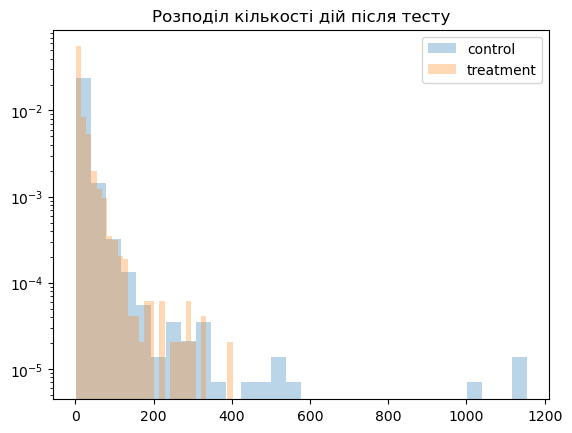

In [848]:
df_aft['group'] = df_aft['sender_id'].apply(lambda x: 'control' if x % 2 == 0 else 'treatment')

column = 'group'
num_act_aft = number_of_actions(df_aft, column)

for i in df_aft[column].unique():
    plt.hist(num_act_aft[num_act_aft[column] == i]['number_of_actions'], bins=30, alpha=0.3, label=i, density=True)

plt.title('Розподіл кількості дій після тесту')
plt.legend()
plt.yscale('log')
plt.show();

In [849]:
num_act_aft.groupby(column)['number_of_actions'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,3726.0,15.466452,44.782857,1.0,2.0,5.0,15.0,1154.0
treatment,3607.0,13.851955,26.280121,1.0,1.0,5.0,16.0,402.0


In [850]:
num_act_aft.groupby(column)['number_of_actions'].agg(lambda x: np.quantile(x, 0.95))

group
control      55.0
treatment    54.7
Name: number_of_actions, dtype: float64

In [851]:
num_act_aft.groupby(column)['number_of_actions'].agg(lambda x: np.quantile(x, 0.99))

group
control      141.75
treatment    112.94
Name: number_of_actions, dtype: float64

In [852]:
df_copy = num_act_aft[num_act_aft['group'] == 'control'].copy()
q = np.quantile(df_copy['number_of_actions'], 0.999)

q999_outlier_control_group = np.quantile(df_copy['number_of_actions'], 0.999)

df_copy[df_copy['number_of_actions'] >= q]

,sender_id,number_of_actions,group
16,3202057642,1131,control
300,3203188184,564,control
538,3204297224,1007,control
543,3204314070,1154,control


In [853]:
df_copy = num_act_aft[num_act_aft['group'] == 'treatment'].copy()
q = np.quantile(df_copy['number_of_actions'], 0.999)

q999_outlier_treat_group = np.quantile(df_copy['number_of_actions'], 0.999)

df_copy[df_copy['number_of_actions'] >= q]

,sender_id,number_of_actions,group
1698,3209547095,308,treatment
1799,3209914479,402,treatment
2961,3214070377,326,treatment
4281,3217001283,324,treatment


Середні значення по контрольній та тестовій групах приблизно рівні: 15.5 проти 13.9. За квантилями: 75% - 15 проти 16, 95% - 55 проти 54.7, 99% — 141 проти 113. Починаючи з 99% квантиля, контрольна група починає показувати викиди, які можуть вплинути на результати тесту. Максимальні значення по групах: 1154 проти 402.

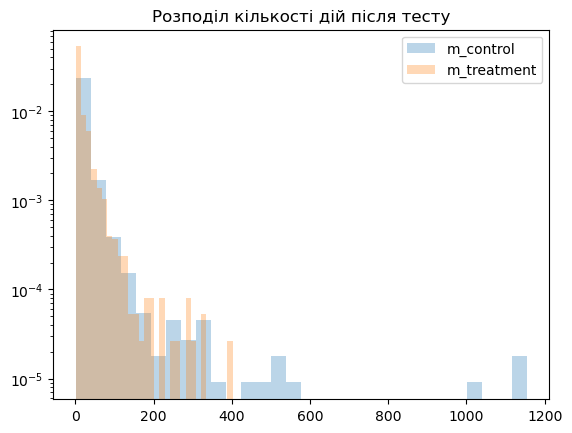

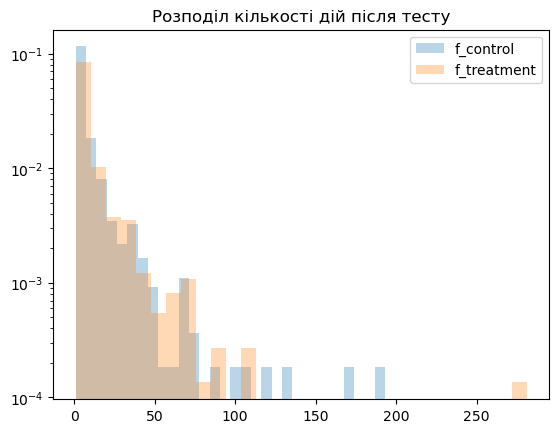

In [854]:
num_act_aft_gen = number_of_actions(df_aft, 'gender')
num_act_aft_gro = number_of_actions(df_aft, 'group')

num_act_aft = pd.merge(
    left=num_act_aft_gen,
    right=num_act_aft_gro,
    how='inner',
    on='sender_id'
)

for i in ['m', 'f']:
    for g in ['control', 'treatment']:
        plt.hist(num_act_aft[(num_act_aft['gender'] == i) & (num_act_aft['group'] == g)]['number_of_actions_x'], \
                 bins=30, alpha=0.3, label=f'{i}_{g}', density=True)

    plt.title('Розподіл кількості дій після тесту')
    plt.legend()
    plt.yscale('log')
    plt.show();

In [855]:
num_act_aft.groupby(['gender', 'group'])['number_of_actions_x'].describe()

count       mean        std  min  25%  50%   75%     max
gender group                                                               
f      control     856.0   8.268692  15.807031  1.0  1.0  3.0   8.0   193.0
       treatment   794.0   8.773300  16.830330  1.0  1.0  4.0   9.0   281.0
m      control    2870.0  17.613240  50.093314  1.0  2.0  6.0  18.0  1154.0
       treatment  2811.0  15.288154  28.230814  1.0  1.5  5.0  18.0   402.0

# 4. Аналіз АБ тесту

In [856]:
num_act_aft = number_of_actions(df_aft, 'group')
num_act_aft.shape, num_act_aft.head()

((7333, 3),
     sender_id  number_of_actions      group
 0  3201946084                  3    control
 1  3201948046                 21    control
 2  3201948762                  7    control
 3  3201960265                  2  treatment
 4  3201991474                 16    control)

In [857]:
q999_outlier_control_group, q999_outlier_treat_group

(532.100000000004, 297.6979999999962)

In [858]:
outliers_control_index = num_act_aft[(num_act_aft['group'] == 'control') & (num_act_aft['number_of_actions'] > q999_outlier_control_group)].index
outliers_treat_index = num_act_aft[(num_act_aft['group'] == 'treatment') & (num_act_aft['number_of_actions'] > q999_outlier_treat_group)].index

outliers = np.concatenate((outliers_control_index.values, outliers_treat_index.values))

len(outliers_control_index), len(outliers_treat_index)

(4, 4)

In [859]:
num_act_aft = num_act_aft.drop(num_act_aft.index[outliers])

In [860]:
num_act_aft.groupby('group')['number_of_actions'].describe().T

group,control,treatment
count,3722.000000,3603.000000
mean,14.447071,13.489870
std,31.285003,23.909778
min,1.000000,1.000000
25%,2.000000,1.000000
50%,5.000000,5.000000
75%,15.000000,16.000000
max,520.000000,291.000000


На проекті, де користувач може відправити лайк іншому користувачу, для збільшення кількості відправлених лайків провели тест на заміну іконки на кнопці з серця на галочку.  При нажатті на хрестик користувача пропонується наступний користувач. Тестовий варіант запустили на користувачів з непарним sender_id 24 березня о 16:00, на парних користувачах залишили базовий варіант.

    H0: Заміна іконки з серця на галочку на кнопці для відправлення лайків не впливає на кількість відправлених лайків користувачами.
    H1: Заміна іконки з серця на галочку на кнопці для відправлення лайків збільшить кількість відправлених лайків користувачами.

In [861]:
control = num_act_aft[num_act_aft['group'] == 'control']['number_of_actions']
treatment = num_act_aft[num_act_aft['group'] == 'treatment']['number_of_actions']

print(f'Кількість користувачів контрольної группи {control.shape[0]}, сгенерували {control.sum()} дій.')
print(f'Кількість користувачів тестової группи {treatment.shape[0]}, сгенерували {treatment.sum()} дій. \n')

alpha = 0.05
tstat, pval = stats.ttest_ind(control, treatment)

if pval < alpha:
    print(f'pvalue {pval:.2f} < {alpha}. Відхиляємо нульову гіпотезу.')
else:
    print(f'pvalue {pval:.2f} > {alpha}. Не відхиляємо нульову гіпотезу.')

Кількість користувачів контрольної группи 3722, сгенерували 53772 дій.
Кількість користувачів тестової группи 3603, сгенерували 48604 дій. 

pvalue 0.14 > 0.05. Не відхиляємо нульову гіпотезу.


# Висновки

1. У датасеті виявлено помилки, такі як неправильний формат стовпців `time_stamp` та `reg_date`, наявність дублікатів і пропущені значення в стовпці `gender`.

2. Усього у стовпці `gender` зафіксовано 171 пропуск, з яких 148 з’явилися до початку тесту, а 23 — після. Всі вони належать трьом користувачам, які зареєструвалися в один день. Це може свідчити про технічну помилку або особливості реєстрації цих користувачів.

3. Оскільки користувачі можуть ставити десятки лайків і дизлайків на хвилину, всі такі рядки позначаються як дублікати.

4. Активність користувачів до і після тесту:
    - до тесту чоловіки були активні переважно з 21:00 до 4:00 (пік о 24:00), а жінки — з 5:00 до 20:00 (з кількома піками о 6:00, 10:00, 11:00, 15:00, 16:00 та 20:00)
    - **після запуску тесту розподіл активності змінився**: більшість дій почали виконуватися у другій половині дня, після 15:00. Чоловіки стали найактивнішими з 23:00 до 4:00 (пік о 23:00), а жінки — з 7:00 до 11:00 та 17:00 до 19:00 (пік 17:00-19:00)

5. **Частота використання платформи:**
    - після тесту у жінок частота використання платформи (`platform_id`) 6 суттєво знизилася — з 72% до 58%. У чоловіків падіння менш значне — з 56% до 52%.

6. Кількість дій до і після тесту:
    - до тесту чоловіки в середньому здійснювали вдвічі більше дій, ніж жінки (32 проти 17). Це співвідношення зберігалося і збільшувалося на більш високих квантилях
    - **після тесту загальна активність значно впала**: середні значення зменшилися вдвічі (16 проти 8), а також скоротилися значення за квантилями

7. Порівняння контрольної та тестової груп. Середні значення по контрольній та тестовій групах залишилися приблизно рівними (15,5 проти 13,9). Проте, починаючи з 99%-го квантиля, контрольна група демонструє значні викиди, які можуть вплинути на результати тесту. Максимальні значення у контрольній групі значно перевищують тестову (1154 проти 402).

8. Перевірка гіпотез:
    - нульова гіпотеза (H0) стверджує, що заміна іконки лайка не впливає на кількість відправлених лайків
    - альтернативна гіпотеза (H1) передбачає, що така зміна збільшить кількість лайків

За результатами тесту:
- контрольна група (3722 користувачі) здійснила 53772 дії (14.4 на користувача)
- тестова група (3603 користувачі) здійснила 48604 дії (13.5 на користувача)
- **p-value = 0.14 > 0.05, що означає, що немає статистично значущих відмінностей між групами**

Таким чином заміна іконки не призвела до збільшення кількості лайків.